In [7]:
import calendar
import pandas as pd
import os
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import regionmask
import numpy as np
import json
import statsmodels.api as sm

In [8]:
global_gdf = gpd.read_file(r"..\crop_calender\shapefiles\gaul0_asap.shp")

In [9]:
def month_part_to_dekad(month_part):
    # Mapping for the part of the month to its dekad index
    part_mapping = {'Beginning': 0, 'Early': 0, 'Mid': 1, 'Middle':1, 'End': 2, 'Late': 2}
    
    try:
        # Splitting the input to extract month and part
        parts = month_part.split(' of ')
        part = parts[0]
        month_name = parts[1]
        
        # Finding the month number from the month name
        month_num = list(calendar.month_name).index(month_name)
        
        # Calculating dekad from month and part
        dekad = (month_num - 1) * 3 + part_mapping[part] + 1
    except:
        dekad = np.nan
    return dekad


def day_to_dekad(day_of_year):
    days_per_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    dekad_count = 0
    
    for month_days in days_per_month:
        if day_of_year <= month_days:
            dekad_in_month = (day_of_year - 1) // 10 + 1
            dekad_in_month = min(dekad_in_month, 3)  # Ensure dekad is within 1 to 3
            return dekad_count + dekad_in_month
        dekad_count += 3
        day_of_year -= month_days
    
    return 36  # Default to the last dekad of December


def smallest_error(value):
    value = abs(value)
    if value < 18:
        return value / 3
    elif value < 36:
        return (36 - value) / 3
    else:
        return 6


def mean_absolute_error(sos_s, sos_e, eos_s, eos_e, sos_s_llm, sos_e_llm, eos_s_llm, eos_e_llm):
    error1 = smallest_error(sos_s - sos_s_llm)
    error2 = smallest_error(sos_e - sos_e_llm)
    error3 = smallest_error(eos_s - eos_s_llm)
    error4 = smallest_error(eos_e - eos_e_llm)
    error = (error1 + error2 + error3 + error4) / 4
    return error

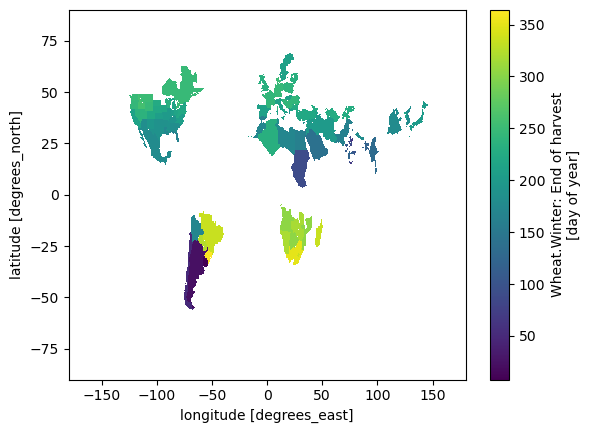

In [10]:
ds = xr.load_dataset(r"..\crop_calender\extracted\Wheat.Winter.crop.calendar.nc.gz")
ds["harvest.end"].plot()

In [11]:
calendar_df = pd.read_csv(r'..\temp_data\crop_calendar_questions.csv', sep=';')

calendar_df["start_planting"] = calendar_df["plant.start"].apply(day_to_dekad)
calendar_df["end_planting"] = calendar_df["plant.end"].apply(day_to_dekad)
calendar_df["start_harvest"] = calendar_df["harvest.start"].apply(day_to_dekad)
calendar_df["end_harvest"] = calendar_df["harvest.end"].apply(day_to_dekad)

calendar_df = calendar_df[['name0', 'name1', 'crop', 'start_planting', 'end_planting', 'start_harvest', 'end_harvest', 'geometry']]
calendar_df = calendar_df.rename(columns={'name0': 'country', 'name1': 'state'})

calendar_df

country               state    crop  start_planting  \
0             Canada    British Columbia  Barley            12.0   
1            Ecuador    Zamora Chinchipe  Barley            29.0   
2           Colombia              Vaupes  Barley             1.0   
3            Finland    Southern Finland  Barley            10.0   
4           Colombia             Guainia  Barley             1.0   
...              ...                 ...     ...             ...   
12196           Togo                Kara    Yams             4.0   
12197  Côte d'Ivoire         Gôh-Djiboua    Yams             4.0   
12198  Côte d'Ivoire  Sassandra-Marahoue    Yams             4.0   
12199         Guinea               Mamou    Yams             7.0   
12200        Nigeria             Bayelsa    Yams             4.0   

       end_planting  start_harvest  end_harvest  \
0              16.0           23.0         29.0   
1               9.0           10.0         26.0   
2              15.0           17.0         26.0   
3              15.0           22.0         27.0   
4              15.0           17.0         26.0   
...             ...            ...          ...   
12196           9.0           19.0          3.0   
12197           9.0           19.0         36.0   
12198           9.0           19.0         36.0   
12199          12.0           22.0          3.0   
12200           9.0           19.0          3.0   

                                                geometry  
0      MULTIPOLYGON (((-130.1930847169999 55.02708053...  
1      POLYGON ((-78.34661187254346 -3.52754402049606...  
2      POLYGON ((-69.41946685999994 -1.07004682799993...  
3      POLYGON ((30.08508127394788 61.82149034412089,...  
4      POLYGON ((-67.64648777067845 3.863684525986173...  
...                                                  ...  
12196  POLYGON ((1.053665765947471 10.18243680394636,...  
12197  POLYGON ((-5.412251816999856 6.648950565000177...  
12198  POLYGON ((-5.72582978499986 7.544388806000143,...  
12199  POLYGON ((-12.5633939999999 11.32323600000007,...  
12200  POLYGON ((6.55999994300015 5.230000019000101, ...  

[12201 rows x 8 columns]

In [12]:
pd.read_csv(r'..\temp_data\crop_calendar_questions.csv', sep=';')


name          name0               name1  \
0               British Columbia, Canada         Canada    British Columbia   
1              Zamora Chinchipe, Ecuador        Ecuador    Zamora Chinchipe   
2                       Vaupes, Colombia       Colombia              Vaupes   
3              Southern Finland, Finland        Finland    Southern Finland   
4                      Guainia, Colombia       Colombia             Guainia   
...                                  ...            ...                 ...   
12196                         Kara, Togo           Togo                Kara   
12197         Gôh-Djiboua, Côte d'Ivoire  Côte d'Ivoire         Gôh-Djiboua   
12198  Sassandra-Marahoue, Côte d'Ivoire  Côte d'Ivoire  Sassandra-Marahoue   
12199                      Mamou, Guinea         Guinea               Mamou   
12200                   Bayelsa, Nigeria        Nigeria             Bayelsa   

         crop  harvest.start  harvest.end  plant.start  plant.end  \
0      Barley          227.0        286.0        116.0      156.0   
1      Barley           91.0        263.0        284.0       90.0   
2      Barley          162.0        263.0         10.0      141.0   
3      Barley          222.0        272.0         99.0      150.0   
4      Barley          162.0        263.0         10.0      141.0   
...       ...            ...          ...          ...        ...   
12196    Yams          182.0         31.0         32.0       90.0   
12197    Yams          182.0        365.0         32.0       90.0   
12198    Yams          182.0        365.0         32.0       90.0   
12199    Yams          213.0         31.0         60.0      120.0   
12200    Yams          182.0         31.0         32.0       90.0   

                                                geometry  asap1_id  \
0      MULTIPOLYGON (((-130.1930847169999 55.02708053...       884   
1      POLYGON ((-78.34661187254346 -3.52754402049606...        49   
2      POLYGON ((-69.41946685999994 -1.07004682799993...        86   
3      POLYGON ((30.08508127394788 61.82149034412089,...       433   
4      POLYGON ((-67.64648777067845 3.863684525986173...       955   
...                                                  ...       ...   
12196  POLYGON ((1.053665765947471 10.18243680394636,...      1837   
12197  POLYGON ((-5.412251816999856 6.648950565000177...      2216   
12198  POLYGON ((-5.72582978499986 7.544388806000143,...      2222   
12199  POLYGON ((-12.5633939999999 11.32323600000007,...      2287   
12200  POLYGON ((6.55999994300015 5.230000019000101, ...      2367   

              start_planting        start_harvest       end_planting  \
0               End of April        Mid of August  Beginning of June   
1             Mid of October   Beginning of April       End of March   
2       Beginning of January          Mid of June         End of May   
3         Beginning of April  Beginning of August         End of May   
4       Beginning of January          Mid of June         End of May   
...                      ...                  ...                ...   
12196  Beginning of February    Beginning of July       End of March   
12197  Beginning of February    Beginning of July       End of March   
12198  Beginning of February    Beginning of July       End of March   
12199     Beginning of March  Beginning of August       End of April   
12200  Beginning of February    Beginning of July       End of March   

            end_harvest                                           question  \
0        Mid of October  When does planting and harvesting of Barley in...   
1      Mid of September  When does planting and harvesting of Barley in...   
2      Mid of September  When does planting and harvesting of Barley in...   
3      End of September  When does planting and harvesting of Barley in...   
4      Mid of September  When does planting and harvesting of Barley in...   
...                 ...                                                ...   
12196 

In [13]:
map_results = pd.read_csv("../temp_data/map_results_old.csv", sep=";")[["model", "country",	"state", "crop", "sos_s_llm", "sos_e_llm", "eos_s_llm","eos_e_llm"]]
map_results

model     country  state            crop           sos_s_llm  \
0        gemma_7b_it  Kyrgyzstan  Talas  Wheat (Spring)        Mid of March   
1        gemma_2b_it  Kyrgyzstan  Talas  Wheat (Spring)    Beginning of May   
2        gpt_4_turbo  Kyrgyzstan  Talas  Wheat (Spring)  Beginning of April   
3      gpt_3_5_turbo  Kyrgyzstan  Talas  Wheat (Spring)        Mid of April   
4         mistral_7b  Kyrgyzstan  Talas  Wheat (Spring)  Beginning of April   
...              ...         ...    ...             ...                 ...   
18046      llama2_7b    Thailand    Tak           Maize   Beginning of June   
18047     llama2_13b    Thailand    Tak           Maize    Beginning of May   
18048    gemma_7b_it    Thailand    Tak     Rice (Main)          Mid of May   
18049    gemma_2b_it    Thailand    Tak     Rice (Main)        Mid of April   
18050  gpt_3_5_turbo    Thailand    Tak     Rice (Main)       Middle of May   

                    sos_e_llm               eos_s_llm              eos_e_llm  
0                End of April             Mid of June            End of July  
1                 Mid of June       Beginning of June            End of June  
2                End of April             End of July          Mid of August  
3            Beginning of May             Mid of July          End of August  
4                Mid of April  Beginning of September         Mid of October  
...                       ...                     ...                    ...  
18046  Beginning of September          Mid of October  Beginning of December  
18047              Mid of May           End of August   Beginning of October  
18048             End of June         Mid of November         Mid of January  
18049              End of May       Beginning of June            End of June  
18050             End of June       Middle of October        End of November  

[18051 rows x 8 columns]

In [14]:
map_results = pd.read_csv("../temp_data/map_results_eval.csv", sep=";")
map_results = map_results.merge(calendar_df, on=["country", "state", "crop"], how="left")               

map_results

question  \
0       When does planting and harvesting of Maize (2)...   
1       When does planting and harvesting of Maize (2)...   
2       When does planting and harvesting of Maize (2)...   
3       When does planting and harvesting of Maize (2)...   
4       When does planting and harvesting of Maize (2)...   
...                                                   ...   
159982  When does planting and harvesting of Rice in T...   
159983  When does planting and harvesting of Rice in T...   
159984  When does planting and harvesting of Rice in A...   
159985  When does planting and harvesting of Rice in S...   
159986  When does planting and harvesting of Rice in F...   

                                          template_answer  \
0       planting start: Beginning of January,\nplantin...   
1       planting start: Beginning of January,\nplantin...   
2       planting start: Beginning of January,\nplantin...   
3       planting start: Beginning of January,\nplantin...   
4       planting start: Beginning of January,\nplantin...   
...                                                   ...   
159982  planting start: Mid of March,\nplanting end: E...   
159983  planting start: Beginning of June,\nplanting e...   
159984  planting start: End of December,\nplanting end...   
159985  planting start: End of August,\nplanting end: ...   
159986  planting start: Mid of April,\nplanting end: E...   

                                           student_answer          model  \
0       \n    Maize (2) in Mato Grosso, Brazil usually...    gemma_7b_it   
1       \n    **Planting:** Mid of May\n\n**Harvesting...    gemma_2b_it   
2       \n     For the first maize season in Mato Gros...     mistral_7b   
3       \n    Start of October, End of October, Beginn...   mistral_8x7b   
4         As an expert in agriculture, I can provide y...      llama2_7b   
...                                                   ...            ...   
159982  Planting start: Mid of May, planting end: Mid ...  gpt_3_5_turbo   
159983  Planting typically starts in the Mid of June a...  gpt_3_5_turbo   
159984  Planting start: Mid of June, planting end: End...  gpt_3_5_turbo   
159985  Planting start: Mid of November, planting end:...  gpt_3_5_turbo   
159986  Planting start: Mid of April, planting end: Mi...  gpt_3_5_turbo   

                           country           state       crop  \
0                           Brazil     Mato Grosso  Maize (2)   
1                           Brazil     Mato Grosso  Maize (2)   
2                           Brazil     Mato Grosso  Maize (2)   
3                           Brazil     Mato Grosso  Maize (2)   
4                           Brazil     Mato Grosso  Maize (2)   
...                            ...             ...        ...   
159982                     Algeria         Tebessa       Rice   
159983                        Mali      Tombouctou       Rice   
159984                       India  Andhra Pradesh       Rice   
159985                   Argentina        Santa Fe       Rice   
159986  Iran (Islamic Republic of)            Fars       Rice   

       multiple_seasons                                         evaluation  \
0                   yes  {\n    "season1": {\n        "planting_start":...   
1                    no  {\n    "planting_start": "Beginning of May",\n...   
2                    no  {\n    "planting_start": "Beginning of Septemb...   
3                    no  {\n    "planting_start": "Beginning of Februar...   
4                    no  {\n    "planting_start": "Mid of October",\n  ...   
...                 ...                                                ...   
159982               no  {\n    "planting_start": "Mid of May",\n    "p...   
159983               no  {\n    "planting_start": "Mid of June",\n    "...   
159984               no  {\n    "planting_start": "Mid of June",\n    "...   
159985               no  {\n    "planting_start": "Mid of November",\n ...   
159986               no  {\n   

In [15]:
def dek_from_dict(dates):
    """Converts the dictionary of dates to dekads"""
    sos_s = month_part_to_dekad(dates["planting_start"])
    sos_e = month_part_to_dekad(dates["planting_end"])
    eos_s = month_part_to_dekad(dates["harvesting_start"])
    eos_e = month_part_to_dekad(dates["harvesting_end"])
    return sos_s, sos_e, eos_s, eos_e


def get_date(row):
    """Gets the dates from the evaluation column"""
    eval = row["evaluation"]
    start_planting = int(row["start_planting"])
    end_planting = int(row["end_planting"])
    start_harvest = int(row["start_harvest"])
    end_harvest = int(row["end_harvest"])

    try:
        dates = json.loads(eval)
        if len(dates) == 4:
            error = mean_absolute_error(start_planting, end_planting, start_harvest, end_harvest, *dek_from_dict(dates))
            return *dek_from_dict(dates), error

        elif len(dates) == 2:
            result1 = dek_from_dict(dates['season1'])
            result2 = dek_from_dict(dates['season2'])
            error1 = mean_absolute_error(start_planting, end_planting, start_harvest, end_harvest, *result1)
            error2 = mean_absolute_error(start_planting, end_planting, start_harvest, end_harvest, *result2)
            if error1 < error2:
                return *result1, error1
            else:
                return *result2, error2

    except:
        return np.nan, np.nan, np.nan, np.nan, np.nan






[236]


In [19]:
map_results[['sos_s_llm', 'sos_e_llm', 'eos_s_llm', 'eos_e_llm', 'error']] = map_results.apply(get_date, axis=1, result_type="expand")
map_results = map_results[['country', 'state', 'crop',  'geometry', 'error', 'model']]

In [20]:
map_results["crop"].unique()

array(['Barley', 'Cassava', 'Maize', 'Millet', 'Potatoes', 'Rice',
       'Sorghum', 'Wheat', 'Yams', 'Maize (2)', 'Oats', 'Oats (Winter)',
       'Pulses', 'Rapeseed (Winter)', 'Rice (2)', 'Rye (Winter)',
       'Sorghum (2)', 'Soybeans', 'Sugarbeets', 'Sunflower',
       'Sweet (Potatoes)', 'Wheat (Winter)'], dtype=object)

In [44]:
grouped = map_results[['error', 'geometry', 'model']].groupby(['geometry', 'model']).mean().reset_index()

# make geometry a geometry object
grouped['geometry'] = gpd.GeoSeries.from_wkt(grouped['geometry'])

gdf = gpd.GeoDataFrame(grouped, geometry='geometry')

# set crs to 4326
gdf.crs = "EPSG:4326"

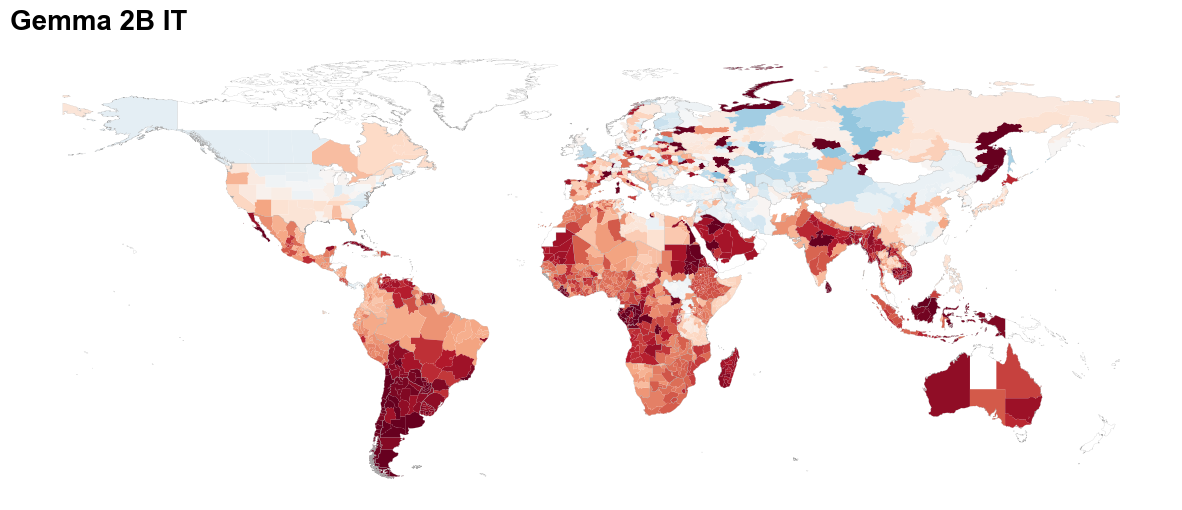

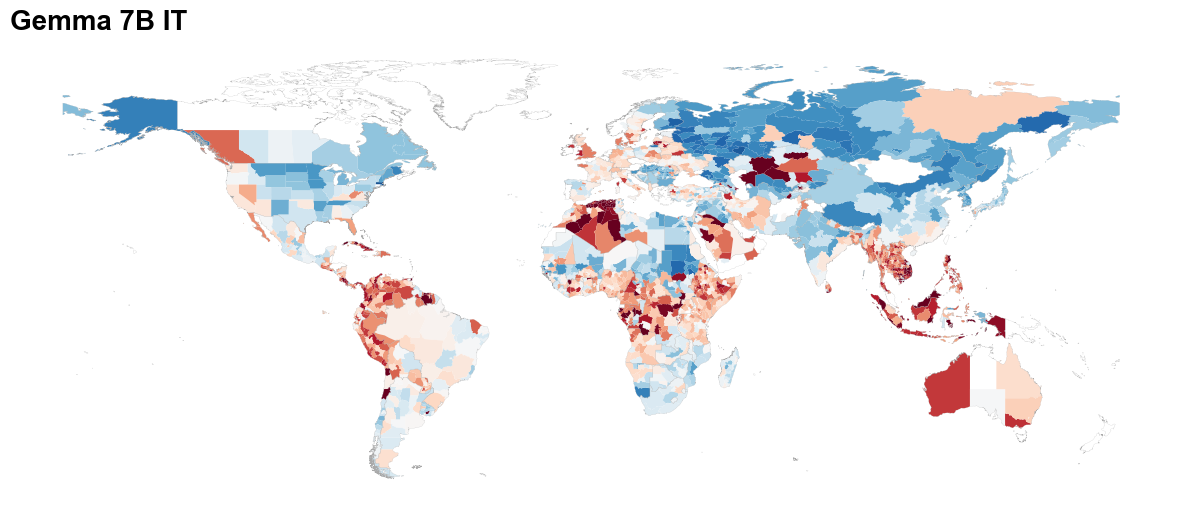

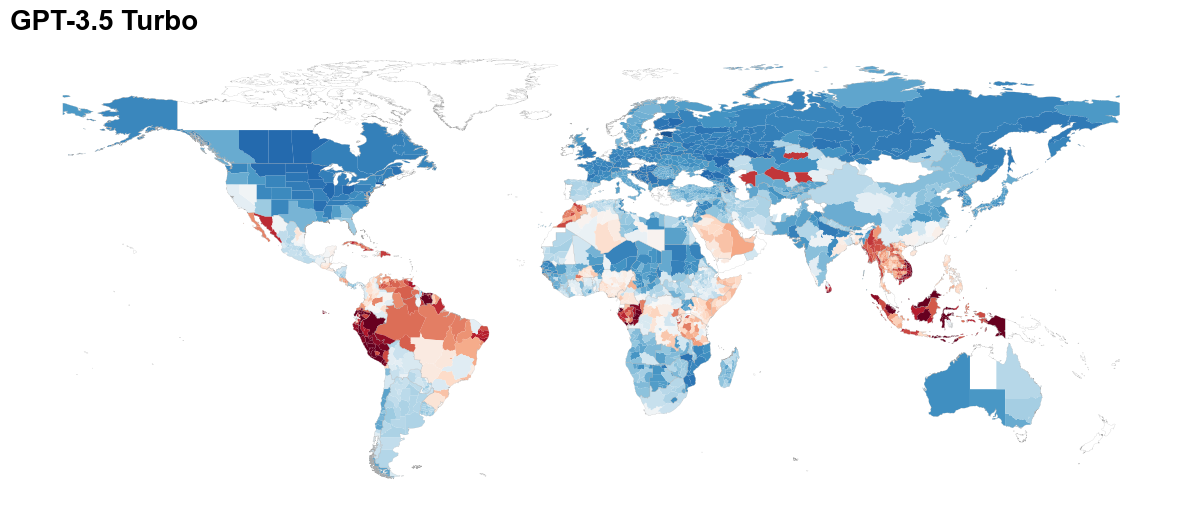

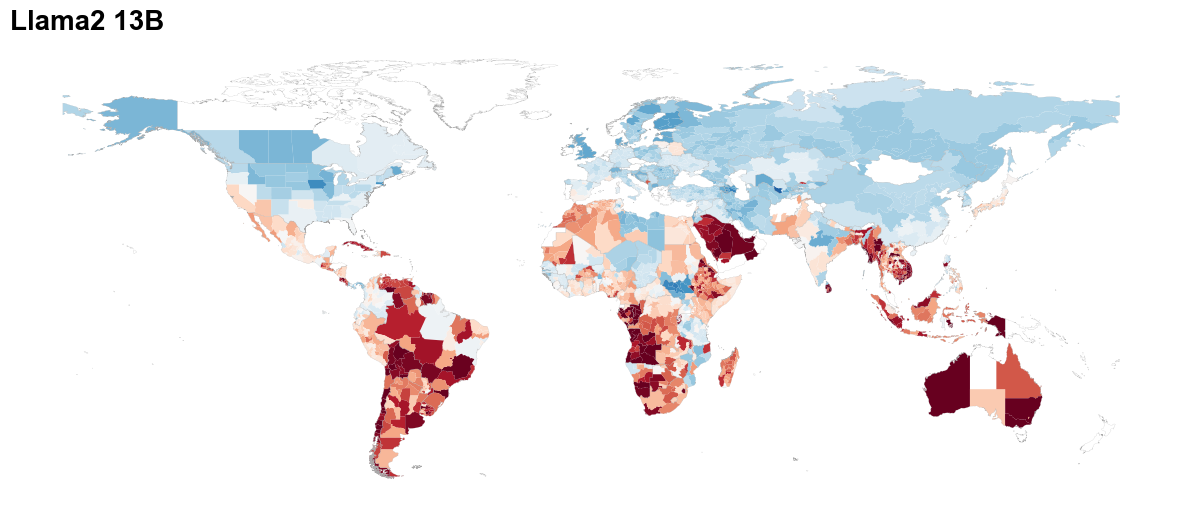

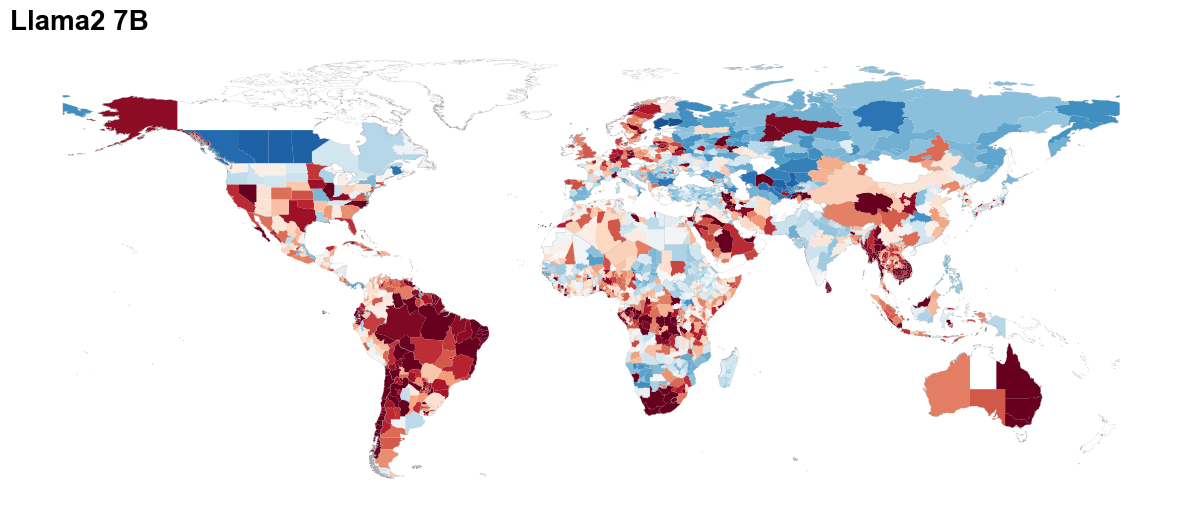

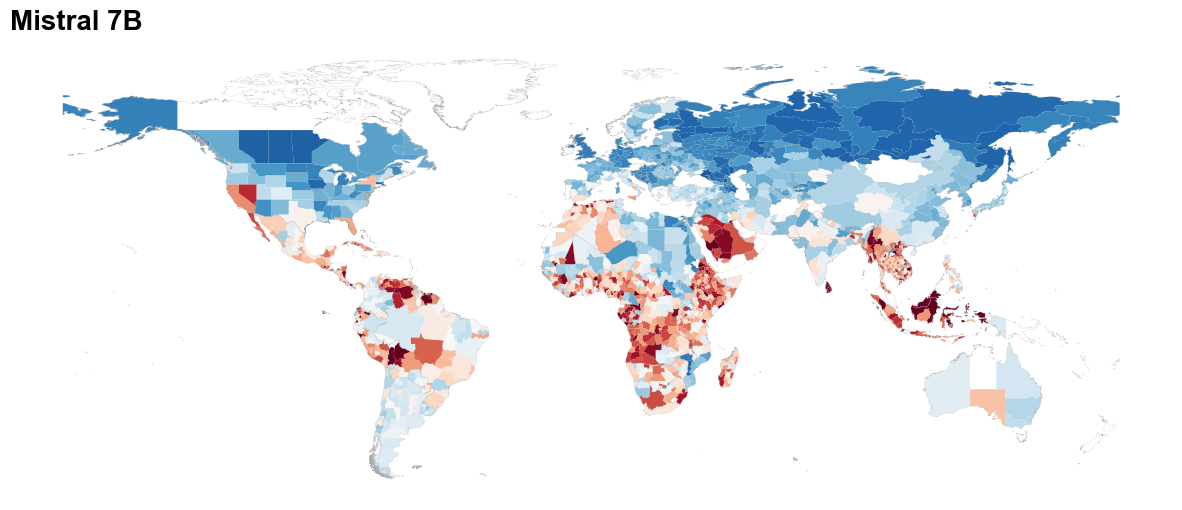

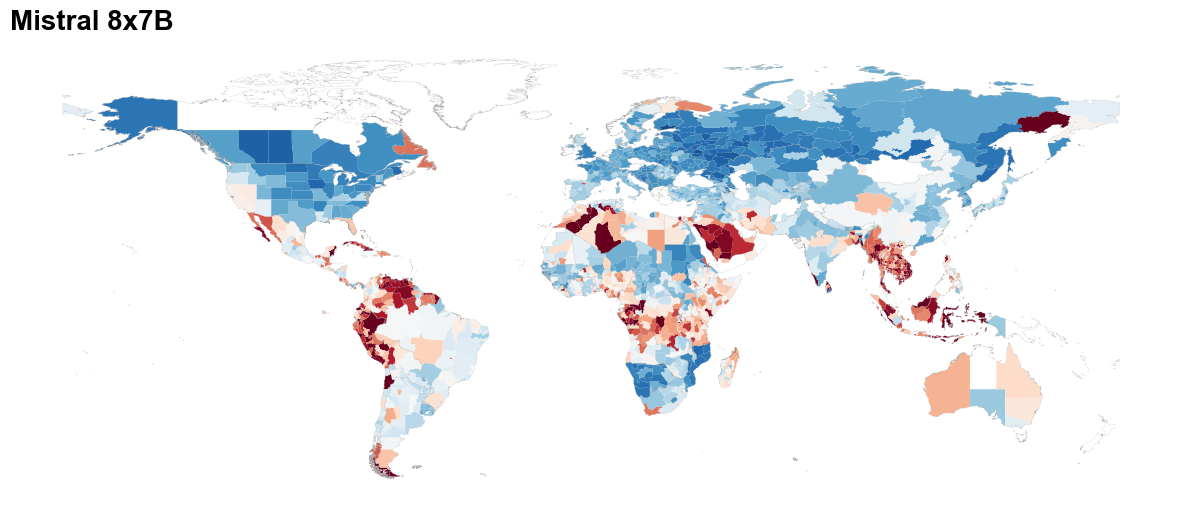

In [46]:
### Maps for individual models

model_name_mapping = {
    'claude_3_sonnet': 'Claude 3 Sonnet',
    'gemma_2b_it': 'Gemma 2B IT',
    'gemma_7b_it': 'Gemma 7B IT',
    'gpt_3_5_turbo': 'GPT-3.5 Turbo',
    'gpt_4_turbo': 'GPT-4 Turbo',
    'llama2_13b': 'Llama2 13B',
    'llama2_7b': 'Llama2 7B',
    'mistral_7b': 'Mistral 7B',
    'mistral_8x7b': 'Mistral 8x7B'
}


for model in ['gemma_2b_it', 'gemma_7b_it', 'gpt_3_5_turbo', 'llama2_13b', 'llama2_7b', 'mistral_7b', 'mistral_8x7b']:
    fig, ax = plt.subplots(1, 1, figsize=(15, 8))
    global_gdf.boundary.plot(ax=ax, linewidth=0.1, color="darkgrey")
    
    # Plot without the default legend
    plot = gdf[gdf['model'] == model].plot(column='error', legend=False, figsize=(10, 6), ax=ax, vmin=0, vmax=3.7, cmap="RdBu_r")
    
    # Create a ScalarMappable object and manually add the colorbar
    #sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=plt.Normalize(vmin=0, vmax=3.7))
    #sm._A = []  # Dummy data for colorbar
    #cbar = fig.colorbar(sm, ax=ax, shrink=0.8, aspect=28, extend='both')
    
    # Left justify the title
    ax.set_title(model_name_mapping[model], loc='left', fontsize=20, fontweight='bold', fontname='Arial', color='black')
    ax.set_axis_off()
    
    # Save the figure
    file_name = f"maps/#all_crops__{model}.png"
    plt.savefig(file_name, bbox_inches='tight', dpi = 400)
    plt.show()  
    plt.close(fig)  



In [58]:
### Maps for individual crops

grouped = map_results[['error', 'geometry', 'crop']].groupby(['geometry', 'crop']).mean().reset_index()


# make geometry a geometry object
grouped['geometry'] = gpd.GeoSeries.from_wkt(grouped['geometry'])

gdf = gpd.GeoDataFrame(grouped, geometry='geometry')
gdf.crs = "EPSG:4326"


for crop in gdf['crop'].unique():
    fig, ax = plt.subplots(1, 1, figsize=(15, 6))
    global_gdf.boundary.plot(ax=ax, linewidth=0.1, color="darkgrey")
    
    # Plot without the default legend
    plot = gdf[gdf['crop'] == crop].plot(column='error', legend=False, figsize=(10, 6), ax=ax, vmin=0, vmax=3.7, cmap="RdBu_r")
    
    # Create a ScalarMappable object and manually add the colorbar
    sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=plt.Normalize(vmin=0, vmax=120))
    sm._A = []  # Dummy data for colorbar
    cbar = fig.colorbar(sm, ax=ax, shrink=0.8, aspect=28, extend='both')
    
    ax.set_title("")
    ax.set_axis_off()
    
    # Save the figure
    file_name = f"maps/all_models__{crop}.png"
    plt.savefig(file_name, bbox_inches='tight', dpi = 400)
    plt.show()  
    plt.close(fig)  # Close the figure after saving to free up memory

KeyboardInterrupt: 

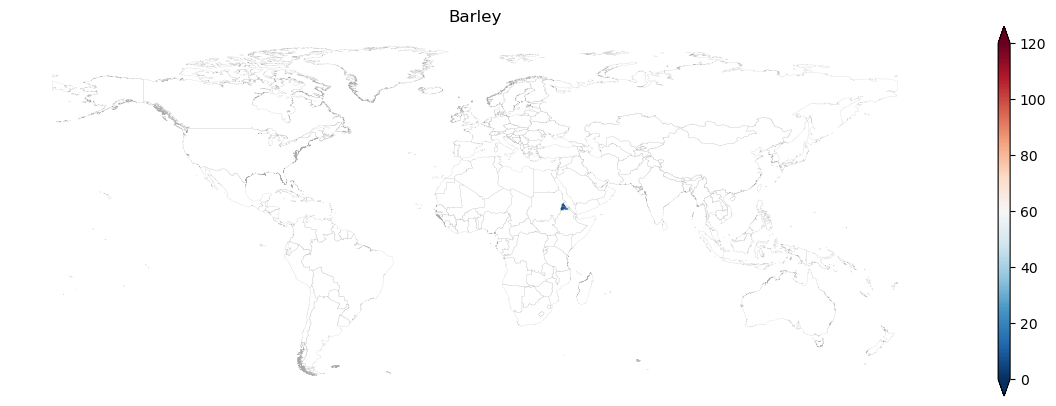

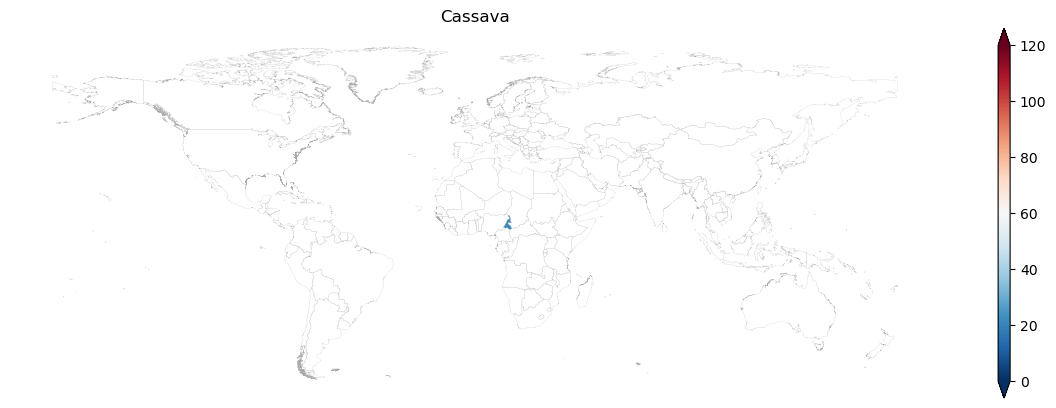

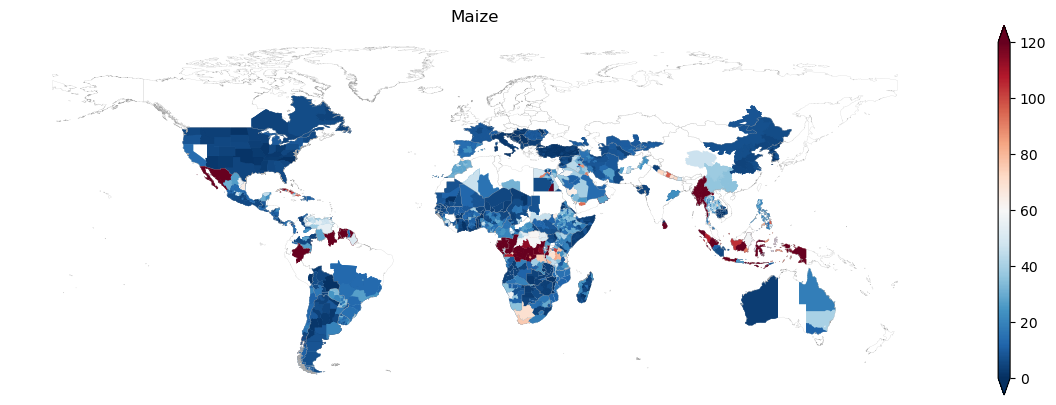

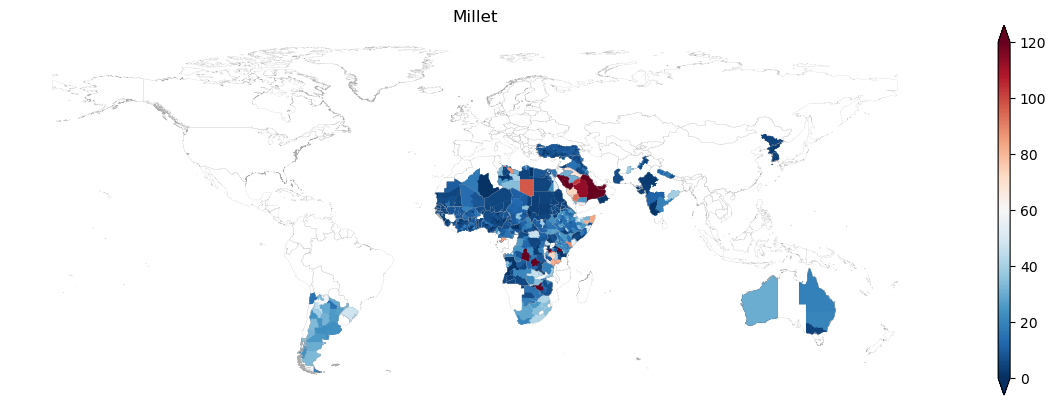

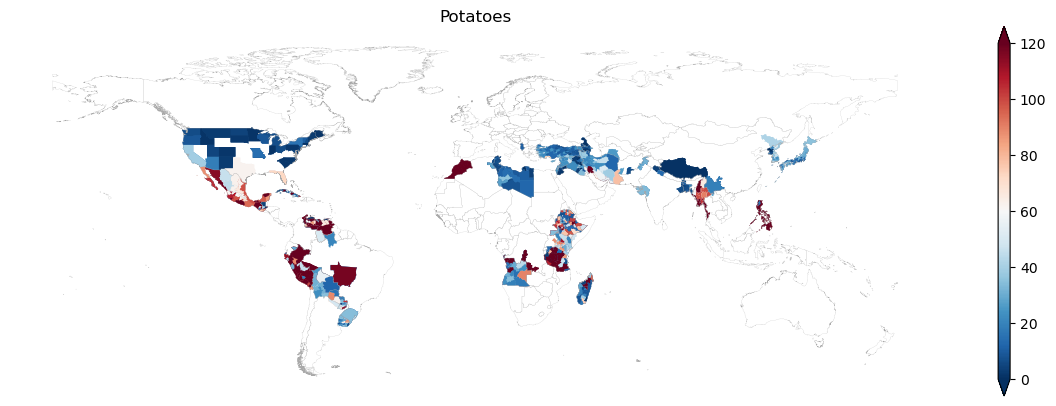

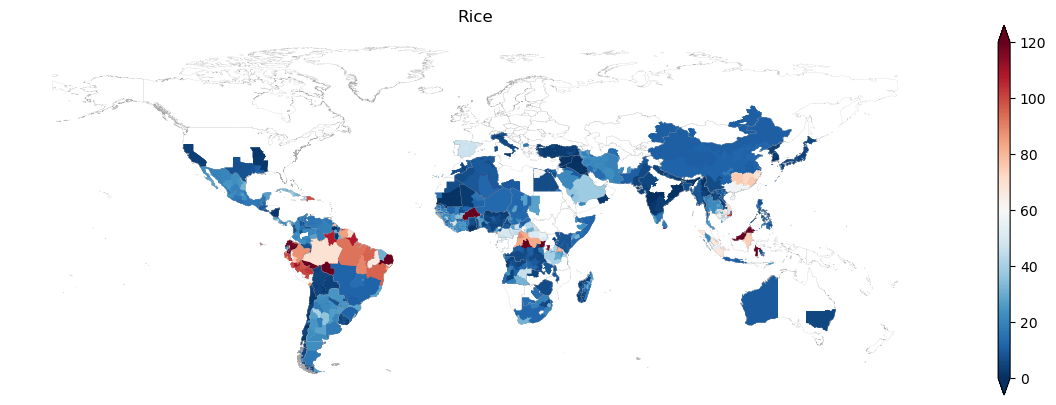

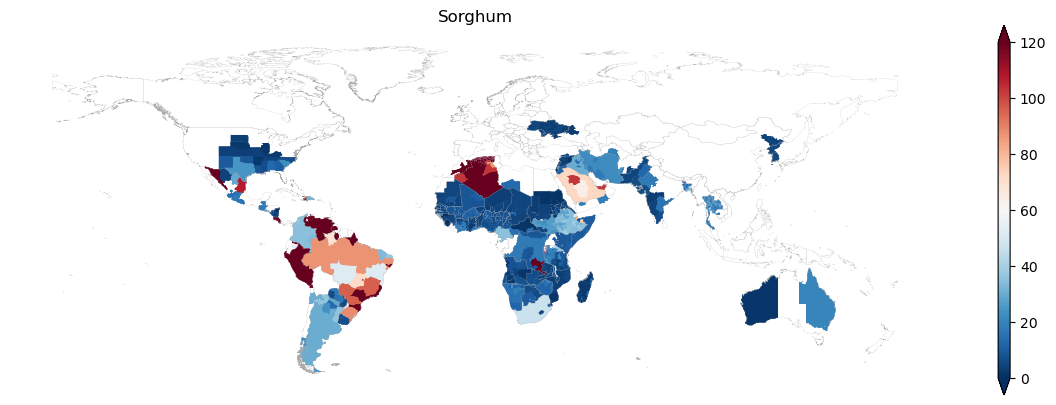

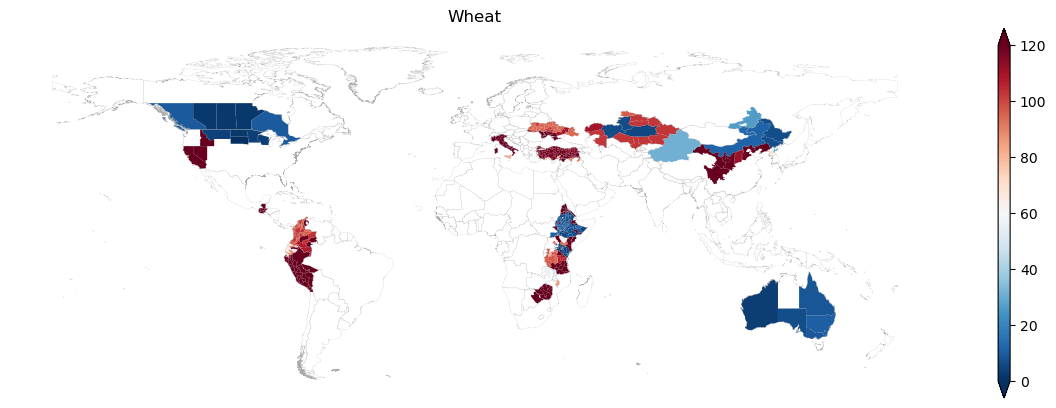

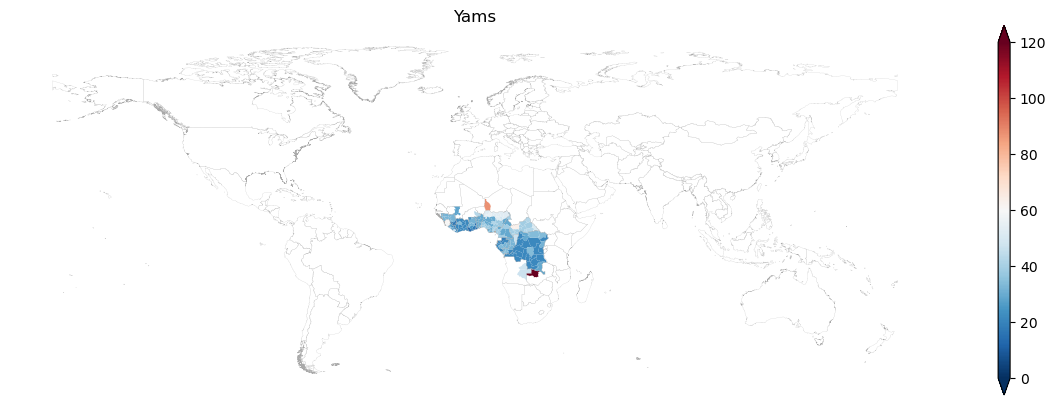

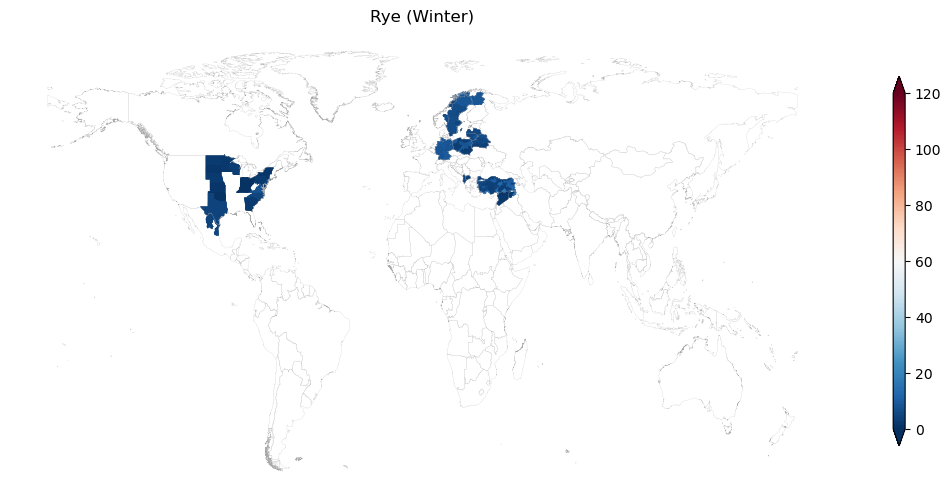

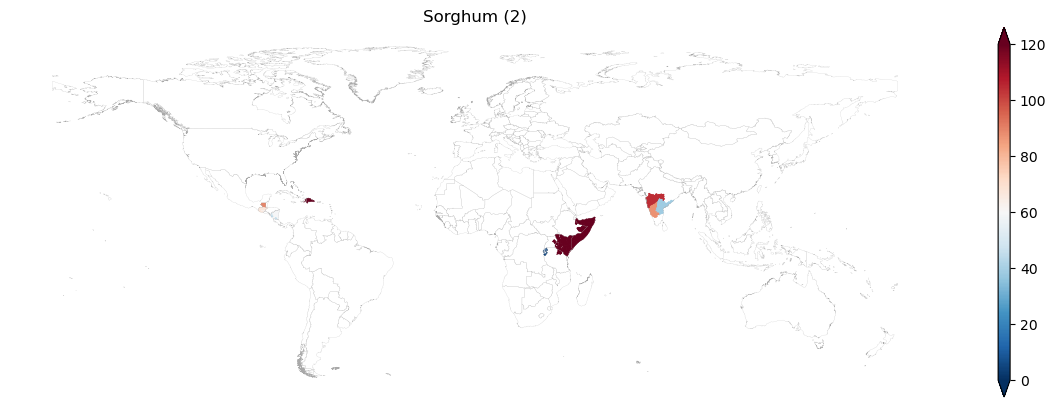

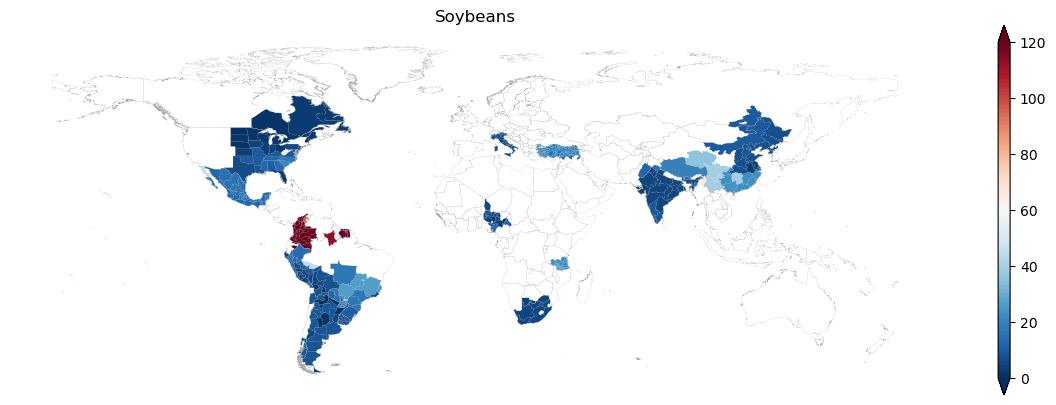

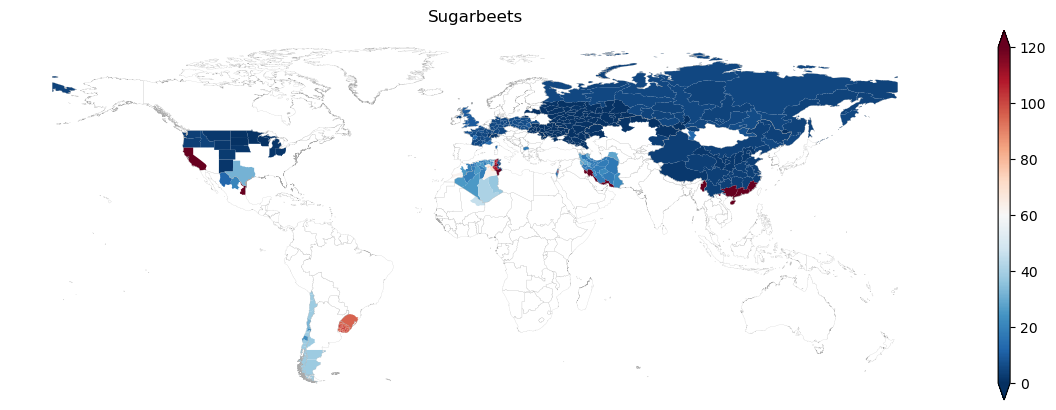

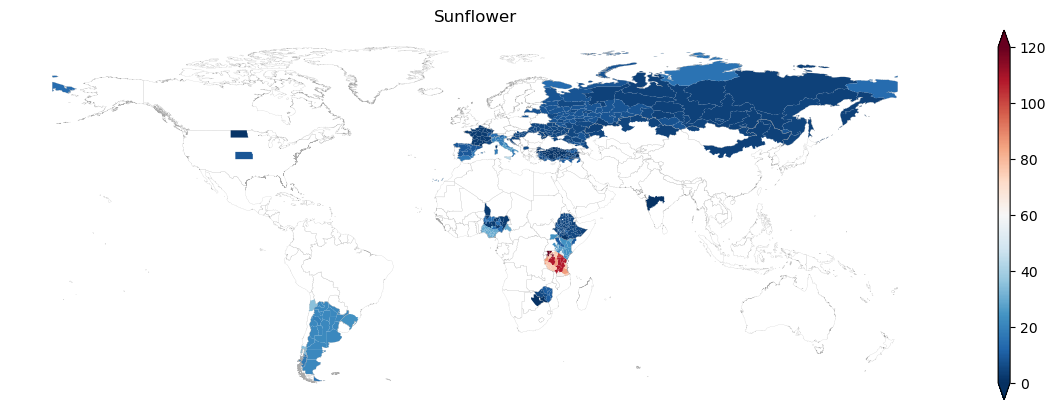

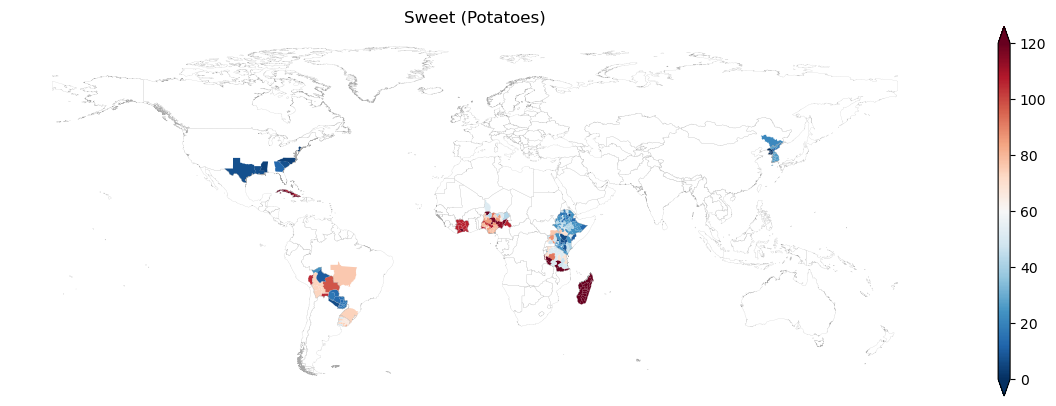

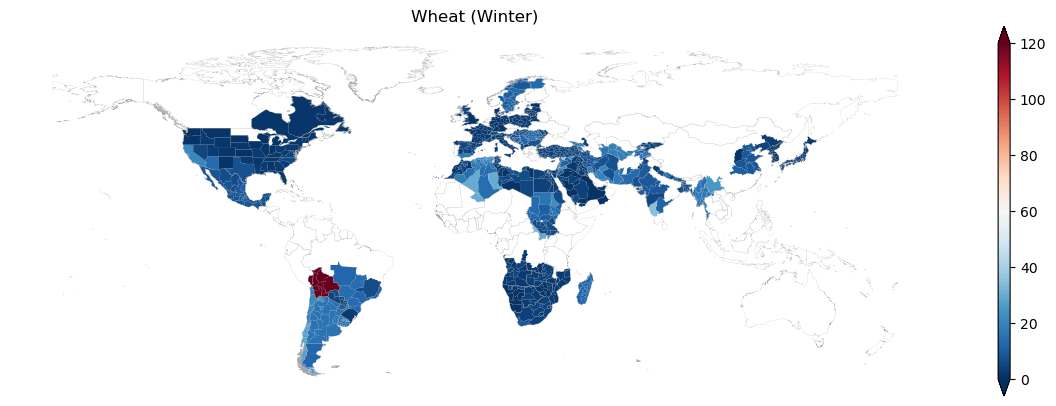

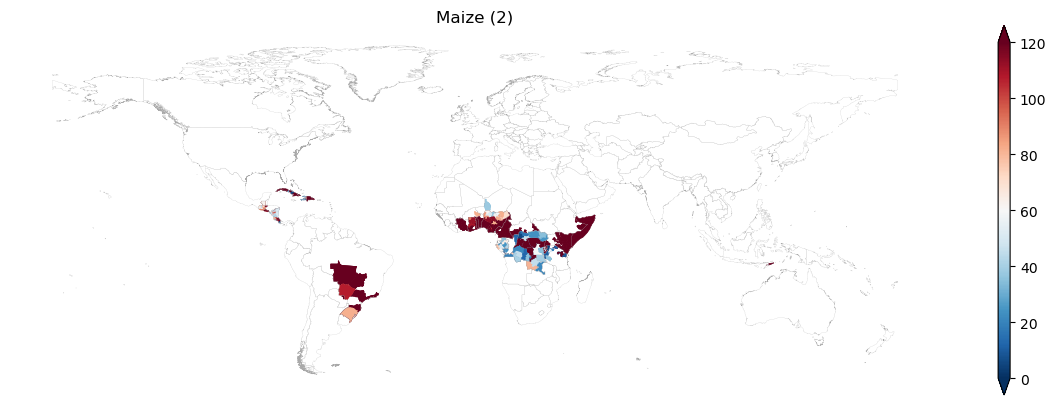

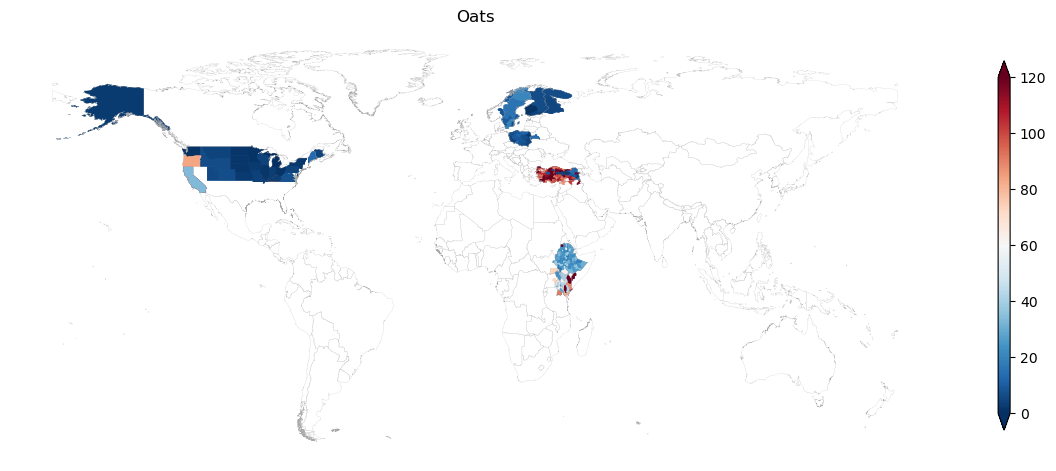

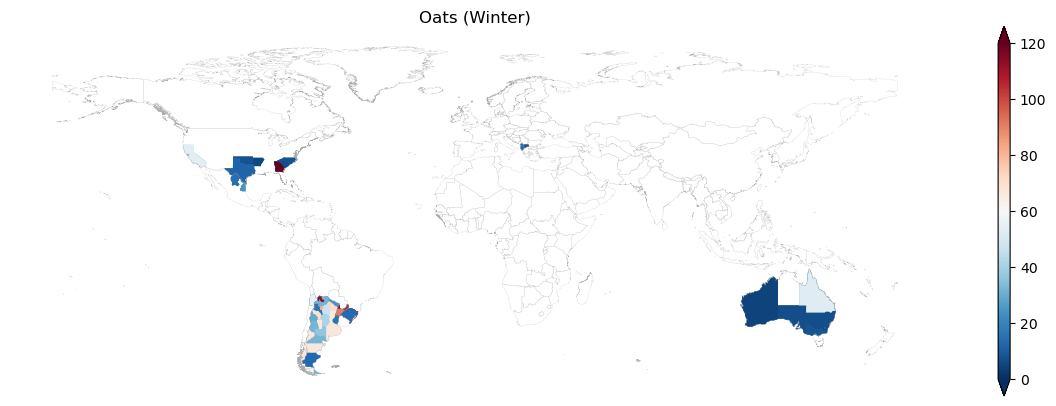

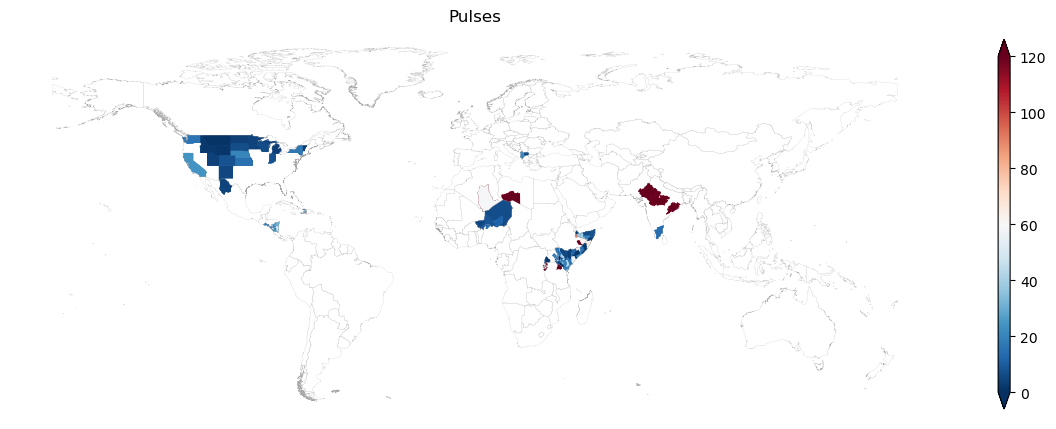

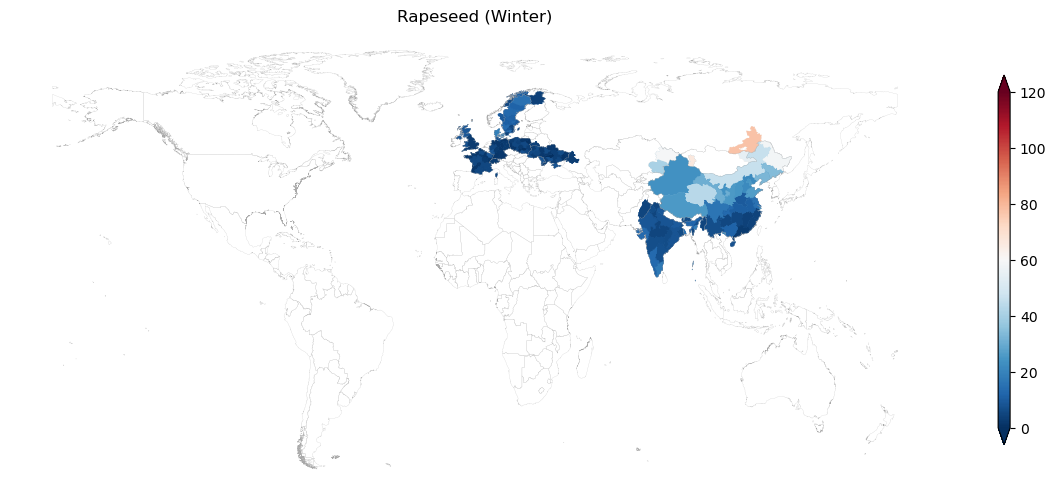

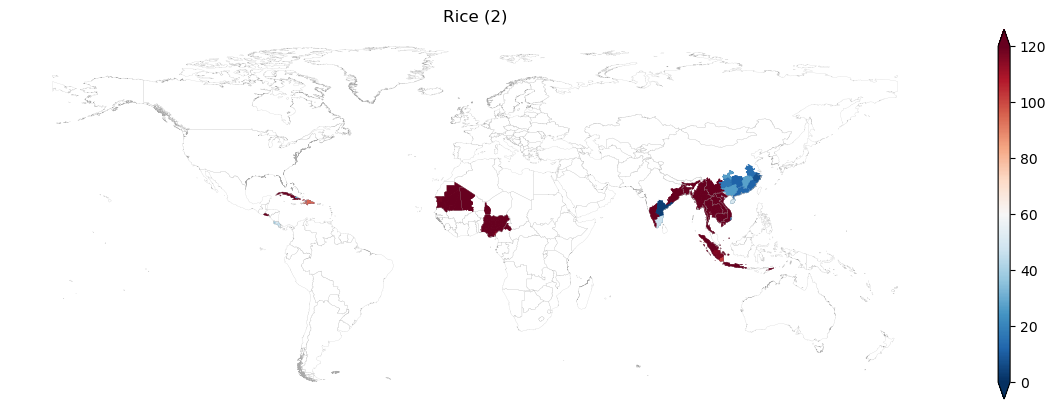

In [23]:
### Maps for GPT-3.5 Turbo

gpt_35_results = map_results[map_results['model']=="gpt_3_5_turbo"][['error', 'geometry', 'crop', 'model']]


# make geometry a geometry object
gpt_35_results['geometry'] = gpd.GeoSeries.from_wkt(gpt_35_results['geometry'])

gdf = gpd.GeoDataFrame(gpt_35_results, geometry='geometry')
gdf.crs = "EPSG:4326"


for crop in gdf['crop'].unique():
    fig, ax = plt.subplots(1, 1, figsize=(15, 6))
    global_gdf.boundary.plot(ax=ax, linewidth=0.1, color="darkgrey")
    
    # Plot without the default legend
    plot = gdf[gdf['crop'] == crop].plot(column='error', legend=False, figsize=(10, 6), ax=ax, vmin=0, vmax=3.7, cmap="RdBu_r")
    
    # Create a ScalarMappable object and manually add the colorbar
    sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=plt.Normalize(vmin=0, vmax=3.7))
    sm._A = []  # Dummy data for colorbar
    cbar = fig.colorbar(sm, ax=ax, shrink=0.8, aspect=28, extend='both')
    
    ax.set_title(crop)
    ax.set_axis_off()
    
    # Save the figure
    file_name = f"maps/gpt_35__{crop}.png"
    plt.savefig(file_name, bbox_inches='tight', dpi = 400)
    plt.show()  
    plt.close(fig)  # Close the figure after saving to free up memory

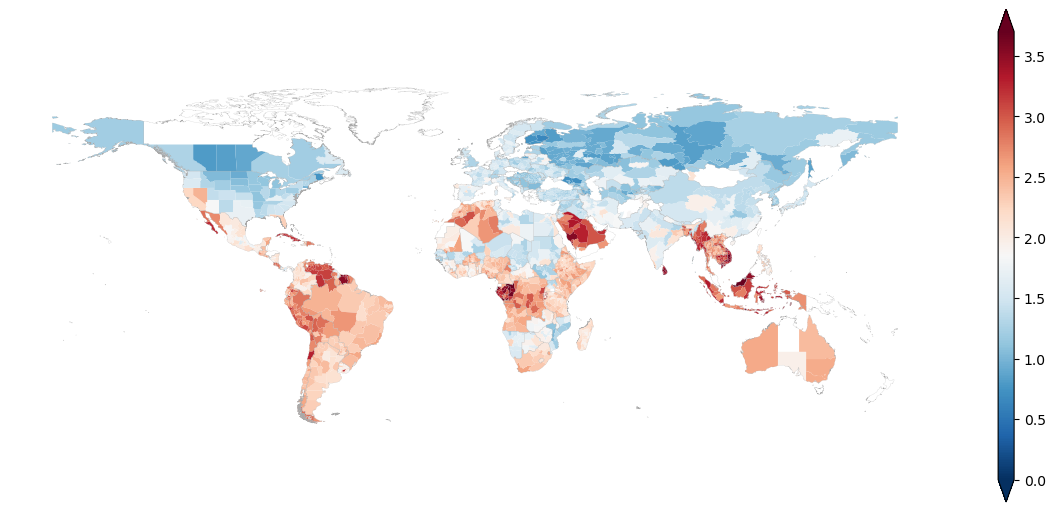

In [60]:
### Maps for total mean


grouped = map_results[['error', 'geometry']].groupby('geometry').mean().reset_index()


# make geometry a geometry object
grouped['geometry'] = gpd.GeoSeries.from_wkt(grouped['geometry'])

gdf = gpd.GeoDataFrame(grouped, geometry='geometry')
gdf.crs = "EPSG:4326"


fig, ax = plt.subplots(1, 1, figsize=(15, 8))
global_gdf.boundary.plot(ax=ax, linewidth=0.1, color="darkgrey")
gdf.plot(column='error', legend=False, figsize=(10, 6), ax = ax, vmin=0, vmax=3.7, cmap = "RdBu_r")
# Create a ScalarMappable object and manually add the colorbar
sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=plt.Normalize(vmin=0, vmax=3.7))
sm._A = []  # Dummy data for colorbar
cbar = fig.colorbar(sm, ax=ax, shrink=0.8, aspect=28, extend='both')
# ax.set_title("Mean", loc='left', fontsize=20, fontweight='bold', fontname='Arial', color='black')
ax.set_axis_off()
file_name = f"maps/total_mean.png"
plt.savefig(file_name, bbox_inches='tight', dpi = 400)
plt.show()

In [33]:
countries = ['Australia',
 'Cambodia',
 'Germany',
 'India',
 'Morocco',
 'Nigeria',
 'South Africa',
 'Uganda',
 'U.K. of Great Britain and Northern Ireland',
 'United States of America']

country_dict = {
   "australia_victoria": "Australia",
   "cambodia": "Cambodia",
   "germany_thuringia": "Germany",
   "india": "India",
   "marocco": "Morocco",
   "nigeria": "Nigeria",
   "south_africa": "South Africa",
   "uganda": "Uganda",
   "uk": "U.K. of Great Britain and Northern Ireland",
   "usa": "United States of America"}

In [34]:
synth_qa_total_results_df = pd.read_csv('../temp_data/synth_qa_eval_gpt4_df.csv', sep = ';')

synth_qa_total_results_df["region"] = synth_qa_total_results_df.apply(lambda x: "usa" if x["region"].startswith("usa") else x["region"], axis=1)


def extract_number(value):
    if value in ["0", "1", 0, 1]:
        return int(value)
    else:
        return None

synth_qa_total_results_df["evaluation"] = synth_qa_total_results_df["evaluation"].apply(extract_number)

# drop nan values
#synth_qa_total_results_df = synth_qa_total_results_df.dropna()

synth_qa_total_results_df = synth_qa_total_results_df[~synth_qa_total_results_df["question"].str.contains("document")]
synth_qa_total_results_df = synth_qa_total_results_df[~synth_qa_total_results_df["question"].str.contains("table")]
synth_qa_total_results_df["country"] = synth_qa_total_results_df["region"].apply(lambda x: country_dict[x])

synth_qa_total_results_df

question  \
0     Region: australia_victoria, Question: What is ...   
1     Region: australia_victoria, Question: What is ...   
2     Region: australia_victoria, Question: When do ...   
3     Region: australia_victoria, Question: When do ...   
4     Region: australia_victoria, Question: What is ...   
...                                                 ...   
1995  Region: usa_south_dakota, Question: What legal...   
1996  Region: usa_south_dakota, Question: What legal...   
1997  Region: usa_south_dakota, Question: What legal...   
1998  Region: usa_south_dakota, Question: What legal...   
1999  Region: usa_south_dakota, Question: What legal...   

                                        template_answer  \
0     The major portion of value in faba bean stubbl...   
1     The major portion of value in faba bean stubbl...   
2     Livestock in Victoria, Australia primarily con...   
3     Livestock in Victoria, Australia primarily con...   
4     The optimal moisture level for harvest in soyb...   
...                                                 ...   
1995  In South Dakota, USA, drainage outlets must no...   
1996  In South Dakota, USA, drainage outlets must no...   
1997  In South Dakota, USA, drainage outlets must no...   
1998  In South Dakota, USA, drainage outlets must no...   
1999  In South Dakota, USA, drainage outlets must no...   

                                             llm_answer          model  \
0     In Victoria, Australia, the major portion of v...    gpt_4_turbo   
1     The major portion of value in faba bean stubbl...  gpt_3_5_turbo   
2     In Victoria, Australia, livestock primarily co...    gpt_4_turbo   
3     Livestock in Victoria, Australia primarily con...  gpt_3_5_turbo   
4     In Victoria, Australia, the optimal moisture l...    gpt_4_turbo   
...                                                 ...            ...   
1995  \n    Sure, here's the information you request...    gemma_2b_it   
1996  \n    1. NRCS Standards: The Natural Resources...     mistral_7b   
1997  \n    \nIn South Dakota, USA, drainage outlets...   mistral_8x7b   
1998    As an expert in agriculture, I can provide y...      llama2_7b   
1999    As an expert in agriculture, I can provide i...     llama2_13b   

                  region                                             prompt  \
0     australia_victoria  You are an expert in agriculture. Answer the g...   
1     australia_victoria  You are an expert in agriculture. Answer the g...   
2     australia_victoria  You are an expert in agriculture. Answer the g...   
3     australia_victoria  You are an expert in agriculture. Answer the g...   
4     australia_victoria  You are an expert in agriculture. Answer the g...   
...                  ...                                                ...   
1995                 usa  You are an expert in agriculture. Answer the g...   
1996                 usa  You are an expert in agriculture. Answer the g...   
1997                 usa  You are an expert in agriculture. Answer the g...   
1998                 usa  You are an expert in agriculture. Answer the g...   
1999                 usa  You are an expert in agriculture. Answer the g...   

      evaluation                   country  
0              0                 Australia  
1              0                 Australia  
2              0                 Australia  
3              0                 Australia  
4              1                 Australia  
...          ...                       ...  
1995           1  United States of America  
1996           0  United States of America  
1997           1  United States of America  
1998           1  United States of America  
1999           1  United States of America  

[2000 rows x 8 columns]

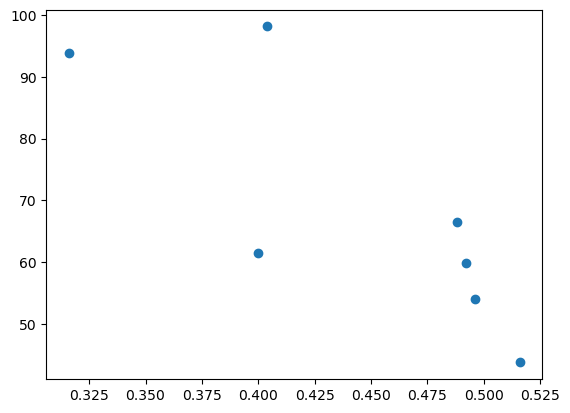

evaluation     error
evaluation    1.000000 -0.804216
error        -0.804216  1.000000

In [35]:
results_ratio1 = synth_qa_total_results_df[["model", "evaluation"]].groupby(['model']).mean().reset_index()
results_ratio2 = map_results[map_results["country"].isin(countries)][["model", "error"]].groupby(['model']).mean().reset_index()


results_ratio = results_ratio1.merge(results_ratio2, on="model", how="inner")
# scatter plot
fig, ax = plt.subplots()
ax.scatter(results_ratio["evaluation"], results_ratio["error"])
plt.show()

# correlation
results_ratio.corr()

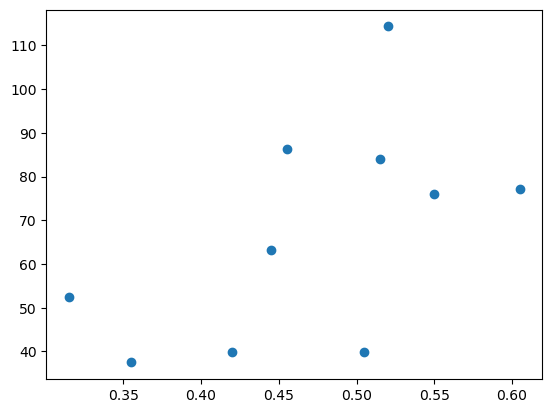

evaluation    error
evaluation     1.00000  0.55374
error          0.55374  1.00000

In [36]:
results_ratio1 = synth_qa_total_results_df[["country", "evaluation"]].groupby(['country']).mean().reset_index()
results_ratio2 = map_results[map_results["country"].isin(countries)][["country", "error"]].groupby(['country']).mean().reset_index()


results_ratio = results_ratio1.merge(results_ratio2, on="country", how="inner")

# scatter plot
fig, ax = plt.subplots()
ax.scatter(results_ratio["evaluation"], results_ratio["error"])
plt.show()

# correlation
results_ratio.corr()

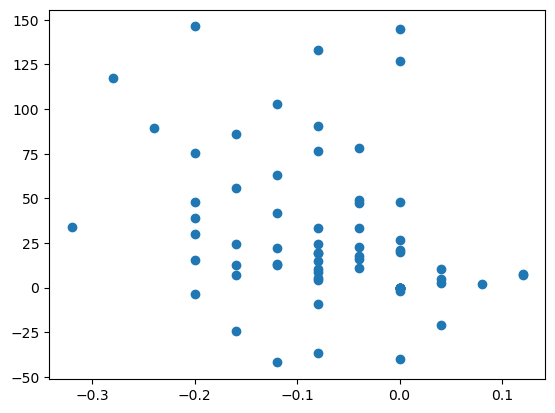

evaluation    error
evaluation     1.00000 -0.32609
error         -0.32609  1.00000

In [37]:
results_ratio1 = synth_qa_total_results_df[["country", "evaluation", 'model']].groupby(['country', 'model']).mean().reset_index()
results_ratio2 = map_results[map_results["country"].isin(countries)][["country", "error", 'model']].groupby(['country', 'model']).mean().reset_index()


def rel_error1(row):
    gpt_35 = results_ratio1[(results_ratio1["country"] == row["country"]) & (results_ratio1["model"] == "gpt_3_5_turbo")]["evaluation"].values[0]
    error = row["evaluation"]
    return (error - gpt_35)

def rel_error2(row):
    gpt_35 = results_ratio2[(results_ratio2["country"] == row["country"]) & (results_ratio2["model"] == "gpt_3_5_turbo")]["error"].values[0]
    error = row["error"]
    return (error - gpt_35) 


results_ratio1["evaluation"] = results_ratio1.apply(rel_error1, axis=1)
results_ratio2["error"] = results_ratio2.apply(rel_error2, axis=1)

results_ratio = results_ratio1.merge(results_ratio2, on=["country", "model"], how="inner")

# scatter plot
fig, ax = plt.subplots()
ax.scatter(results_ratio["evaluation"], results_ratio["error"])
plt.show()

# correlation
results_ratio.corr()

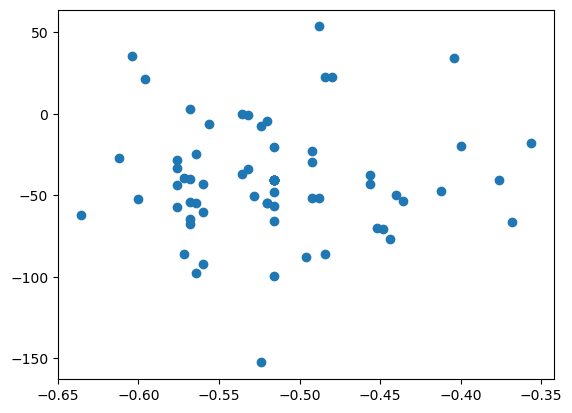

evaluation     error
evaluation    1.000000  0.029627
error         0.029627  1.000000

In [38]:
results_ratio1 = synth_qa_total_results_df[["country", "evaluation", 'model']].groupby(['country', 'model']).mean().reset_index()
results_ratio2 = map_results[map_results["country"].isin(countries)][["country", "error", 'model']].groupby(['country', 'model']).mean().reset_index()


def rel_error1(row):
    gpt_35 = results_ratio1[(results_ratio1["country"] == row["country"]) & (results_ratio1["model"] == "gpt_3_5_turbo")]["evaluation"].values[0]
    model_mean = results_ratio1[results_ratio1["model"] == row["model"]]["evaluation"].mean()
    error = row["evaluation"]
    return (error - gpt_35 - model_mean)

def rel_error2(row):
    gpt_35 = results_ratio2[(results_ratio2["country"] == row["country"]) & (results_ratio2["model"] == "gpt_3_5_turbo")]["error"].values[0]
    model_mean = results_ratio2[results_ratio2["model"] == row["model"]]["error"].mean()
    error = row["error"]
    return (error - gpt_35 - model_mean)


results_ratio1["evaluation"] = results_ratio1.apply(rel_error1, axis=1)
results_ratio2["error"] = results_ratio2.apply(rel_error2, axis=1)

results_ratio = results_ratio1.merge(results_ratio2, on=["country", "model"], how="inner")

# scatter plot
fig, ax = plt.subplots()
ax.scatter(results_ratio["evaluation"], results_ratio["error"])
plt.show()

# correlation
results_ratio.corr()

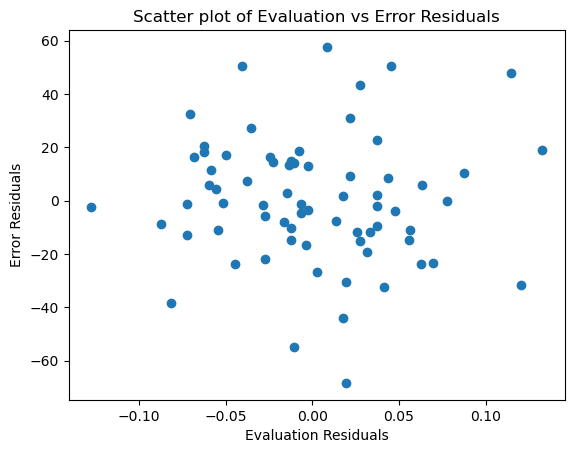

Correlation (r): -0.037702894312576965
R-squared: 0.0014215082395453485


In [41]:
# Define the function to fit the linear model and get residuals
def get_residuals(df, dependent_var, predictors):
    X = pd.get_dummies(df[predictors], drop_first=True)
    X = sm.add_constant(X)
    y = df[dependent_var]
    model = sm.OLS(y, X).fit()
    df['residuals'] = model.resid
    return df

# Fit linear models to account for region and model effect and get residuals for both datasets
results_ratio1 = get_residuals(results_ratio1, 'evaluation', ['country', 'model'])
results_ratio2 = get_residuals(results_ratio2, 'error', ['country', 'model'])

# Merge the residuals
results_ratio = results_ratio1[['country', 'model', 'residuals']].merge(
    results_ratio2[['country', 'model', 'residuals']],
    on=['country', 'model'],
    suffixes=('_evaluation', '_error')
)

# Scatter plot of residuals
fig, ax = plt.subplots()
ax.scatter(results_ratio["residuals_evaluation"], results_ratio["residuals_error"])
plt.xlabel('Evaluation Residuals')
plt.ylabel('Error Residuals')
plt.title('Scatter plot of Evaluation vs Error Residuals')
plt.show()

# Correlation of residuals
correlation = results_ratio[['residuals_evaluation', 'residuals_error']].corr()

r = correlation.iloc[0, 1]
r_squared = r ** 2
print(f"Correlation (r): {r}")
print(f"R-squared: {r_squared}")

In [ ]:
results_ratio

country          model  evaluation      error
0                  Australia    gemma_2b_it      -0.596  21.354668
1                  Australia    gemma_7b_it      -0.520  -4.627862
2                  Australia  gpt_3_5_turbo      -0.516 -40.884618
3                  Australia     llama2_13b      -0.488  53.499555
4                  Australia      llama2_7b      -0.604  35.575839
..                       ...            ...         ...        ...
65  United States of America  gpt_3_5_turbo      -0.516 -40.884618
66  United States of America     llama2_13b      -0.528 -50.352538
67  United States of America      llama2_7b      -0.564 -24.690018
68  United States of America     mistral_7b      -0.612 -27.357161
69  United States of America   mistral_8x7b      -0.536 -37.005556

[70 rows x 4 columns]

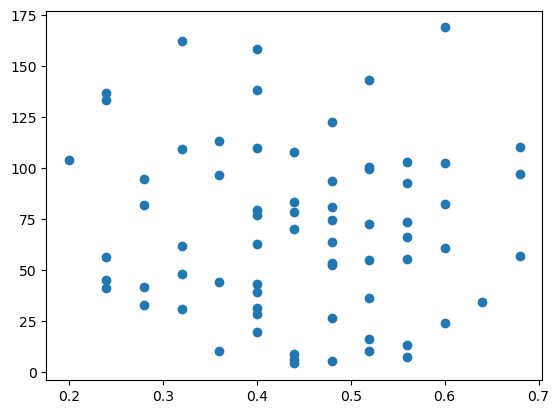

evaluation   error
evaluation      1.0000 -0.0487
error          -0.0487  1.0000

In [ ]:
results_ratio1 = synth_qa_total_results_df[["country", "evaluation", 'model']].groupby(['country', 'model']).mean().reset_index()
results_ratio2 = map_results[map_results["country"].isin(countries)][["country", "error", 'model']].groupby(['country', 'model']).mean().reset_index()

results_ratio = results_ratio1.merge(results_ratio2, on=["country", "model"], how="inner")

# scatter plot
fig, ax = plt.subplots()
ax.scatter(results_ratio["evaluation"], results_ratio["error"])
plt.show()

# correlation
results_ratio.corr()

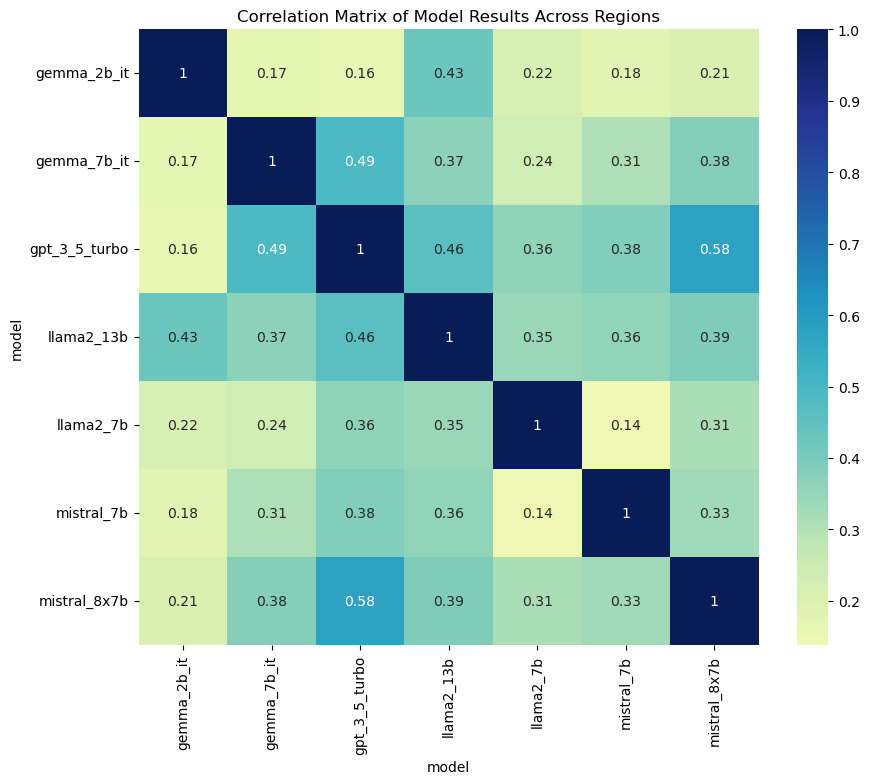

In [ ]:
import seaborn as sns

results_ratio = map_results[["country", "state", "crop", "error", "model"]][~map_results["model"].isin(["claude_3_sonnet", "gpt_4_turbo"])]

pivot_df = results_ratio.pivot_table(index=["country", "state", "crop"], columns='model', values='error')#.dropna()

# Compute correlations between model results across regions
correlations = pivot_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='YlGnBu', center=0.51)

plt.title('Correlation Matrix of Model Results Across Regions')
plt.show()

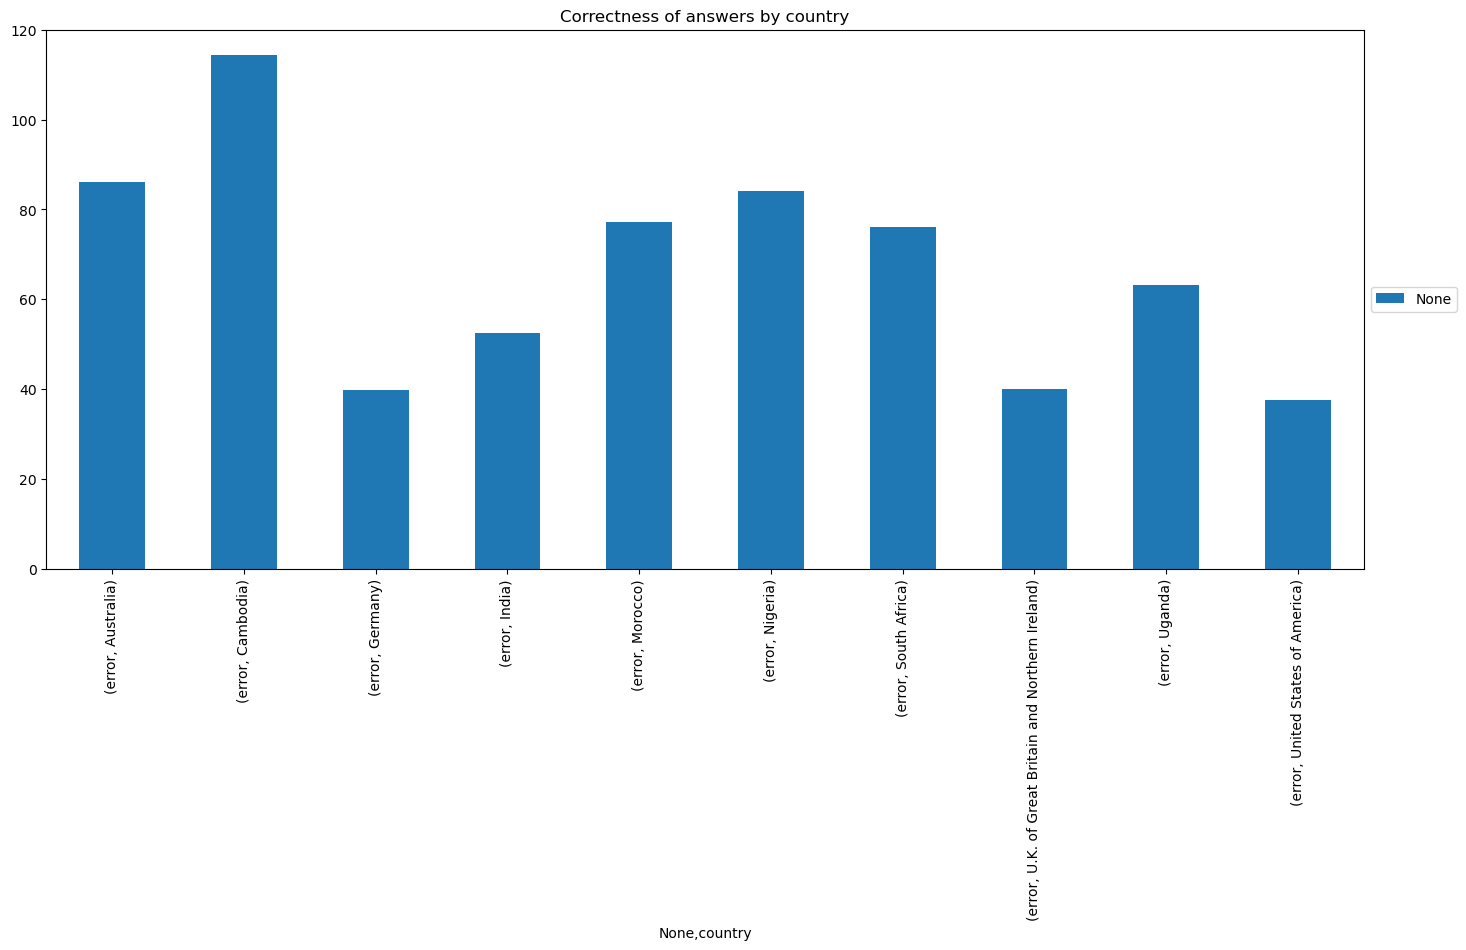

In [ ]:
# sum error by country
map_results['error'].dropna(inplace=True)

results_ratio = map_results[map_results["country"].isin(countries)][["country", "error"]].groupby(['country']).mean() # results_sum / results_count


cmap = plt.cm.viridis

# Generate a list of colors from the 'viridis' colormap
colors = cmap(np.linspace(0, 1, 5))#results_ratio.shape[0]//2))

# Plot the data
ax = results_ratio.unstack().plot(kind='bar', stacked=False, figsize=(17, 7))
#ax = results_ratio.reset_index()[results_ratio.reset_index()["model"]!="gemma_2b_it"][["country", "error"]].groupby('country').mean().unstack().plot(kind='bar', stacked=False, figsize=(17, 7))
plt.title("Correctness of answers by country")

# Place the legend to the right of the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [ ]:

results_ratio = map_results[["error", "model"]].groupby(['model']).mean() # results_sum / results_count

cmap = plt.cm.viridis

# Generate a list of colors from the 'viridis' colormap
colors = cmap(np.linspace(0, 1, 5))#results_ratio.shape[0]//2))

# Plot the data
ax = results_ratio.unstack().plot(kind='bar', stacked=False, figsize=(17, 7))
#ax = results_ratio.reset_index()[results_ratio.reset_index()["model"]!="gemma_2b_it"][["country", "error"]].groupby('country').mean().unstack().plot(kind='bar', stacked=False, figsize=(17, 7))
plt.title("Correctness of answers by model")

# Place the legend to the right of the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()